## Multivariate Time Series Analysis


In [32]:
from IPython.display import display, Markdown
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
plt.style.use('ggplot')

In [33]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

### Import Data



In [34]:
dic_country = \
{'AUS': 'Australia',
 'BRA': 'Brazil',
 'CAN': 'India',
 'CHN': 'China',
 'GBR': 'United Kingdom',
 'IND': 'India',
 'JPN': 'Japan',
 'SGP': 'Singapore',
 'USA': 'United States'}
pd.DataFrame(dic_country,index=[0]).T.reset_index().rename(columns = {'index': 'country_code', 0: 'country_name'})

,country_code,country_name
0,AUS,Australia
1,BRA,Brazil
2,CAN,India
3,CHN,China
4,GBR,United Kingdom
5,IND,India
6,JPN,Japan
7,SGP,Singapore
8,USA,United States


In [35]:
Data_dic_m = pd.ExcelFile('Manufacturing_filled.xlsx')
Data_dic_s = pd.ExcelFile('Service_filled.xlsx')

In [36]:
def get_sheet_by_methods(data, method_num, verbose = 0):
  sheet_names = data.sheet_names
  sheet_imputation_map = pd.DataFrame([[s, s[:3].strip(),s[3:]] for s in sheet_names], columns = ['sheet_name', 'country_code', 'imputation method'])
  methods = sheet_imputation_map['imputation method'].unique()
  if verbose:
    print('methods tried:',methods, len(methods))
  return list(sheet_imputation_map.loc[sheet_imputation_map['imputation method'] == methods[method_num]]['sheet_name'].values)

In [37]:
m_dfs = {}
for i in range(len(Data_dic_m.sheet_names) // 10):
  for sheet in get_sheet_by_methods(Data_dic_m, i):
    df = pd.read_excel(Data_dic_m, sheet_name=sheet)
    df['Year'] = [i.year for i in pd.to_datetime(df.Year, format='%Y')]
    df = df.set_index('Year')
    m_dfs[(sheet[:3], sheet[3:].strip())] = df

In [38]:
s_dfs = {}
for i in range(len(Data_dic_s.sheet_names) // 10):
  for sheet in get_sheet_by_methods(Data_dic_s, i):
    df = pd.read_excel(Data_dic_s, sheet_name=sheet)
    df['Year'] = [i.year for i in pd.to_datetime(df.Year, format='%Y')]
    df = df.set_index('Year')
    s_dfs[(sheet[:3], sheet[3:].strip())] = df

In [39]:
# way to retrieve method and country
method = ['Mean','Median','LOCF','NOCB','Rolling statistics']
country = list(dic_country.keys())

m_dfs[(country[0],method[0])] # stands for AUS mean data

,Employment_in_industry_male,Research_development_expenditure,Researchers in R&D,Population_labor_rate,Population_density,Foreign_direct_investment,Air_freight_million_ton_km,Container_port_traffic_TEU,Industry_value_added_current_USD,GDP_per_capita_current_USD,Final_consumption,New_business_density,Employment_in_industry_%_of_total_employment,Manufacturing_value added_%_of_GDP
Year,,,,,,,,,,,,,,
1990,30.583793,1.949895,3899.104492,66.851833,2.221353,2.716689,1222.300049,6.401304e+06,8.961370e+10,18243.471418,2.255137e+11,12.667971,21.196207,13.793444
1991,31.709999,1.949895,3899.104492,66.860327,2.249847,0.801486,1222.599976,6.401304e+06,9.012950e+10,18855.761996,2.458261e+11,12.667971,23.510000,12.569810
1992,31.709999,1.949895,3899.104492,66.781131,2.277313,1.518343,1361.500000,6.401304e+06,8.745366e+10,18604.188270,2.539214e+11,12.667971,23.290001,12.580159
1993,31.670000,1.949895,3899.104492,66.662599,2.299702,1.702015,1525.800049,6.401304e+06,8.372119e+10,17667.187100,2.409823e+11,12.667971,23.299999,12.873184
1994,31.719999,1.949895,3899.104492,66.582205,2.324174,1.381160,1645.500000,6.401304e+06,8.644760e+10,18079.380179,2.456195e+11,12.667971,23.170000,13.205020
1995,31.219999,1.949895,3899.104492,66.572593,2.352420,3.606498,1737.500000,6.401304e+06,9.723938e+10,20358.333356,2.794402e+11,12.667971,22.629999,13.123677
1996,30.610001,1.663230,3355.864990,66.555719,2.383531,1.137889,1833.699951,6.401304e+06,1.041882e+11,21904.294118,3.034181e+11,12.667971,22.129999,12.742416
1997,30.320000,1.949895,3899.104492,66.598197,2.410346,1.857942,1953.800049,6.401304e+06,1.097684e+11,23509.423468,3.258452e+11,12.667971,21.850000,12.303665
1998,30.129999,1.514530,3382.171875,66.676387,2.435599,1.902235,1904.400024,6.401304e+06,1.013654e+11,21345.970987,3.004165e+11,12.667971,21.510000,12.470748


### Time Series Visualization

In [40]:
# can change the argument to plot different country and type
def plot_time_series(df, var_num):
  fig, axes = plt.subplots(var_num//4 + 1,4, dpi=120, figsize=(10,6))
  for i, ax in enumerate(axes.flatten()):
      if (i >= var_num - 1): break
      data = df[df.columns[i]]
      ax.plot(data, color = "lightblue",ms = 1)
      # Decorations
      ax.set_title(df.columns[i+1],fontsize=5)
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=4)

  plt.tight_layout()
  plt.show()

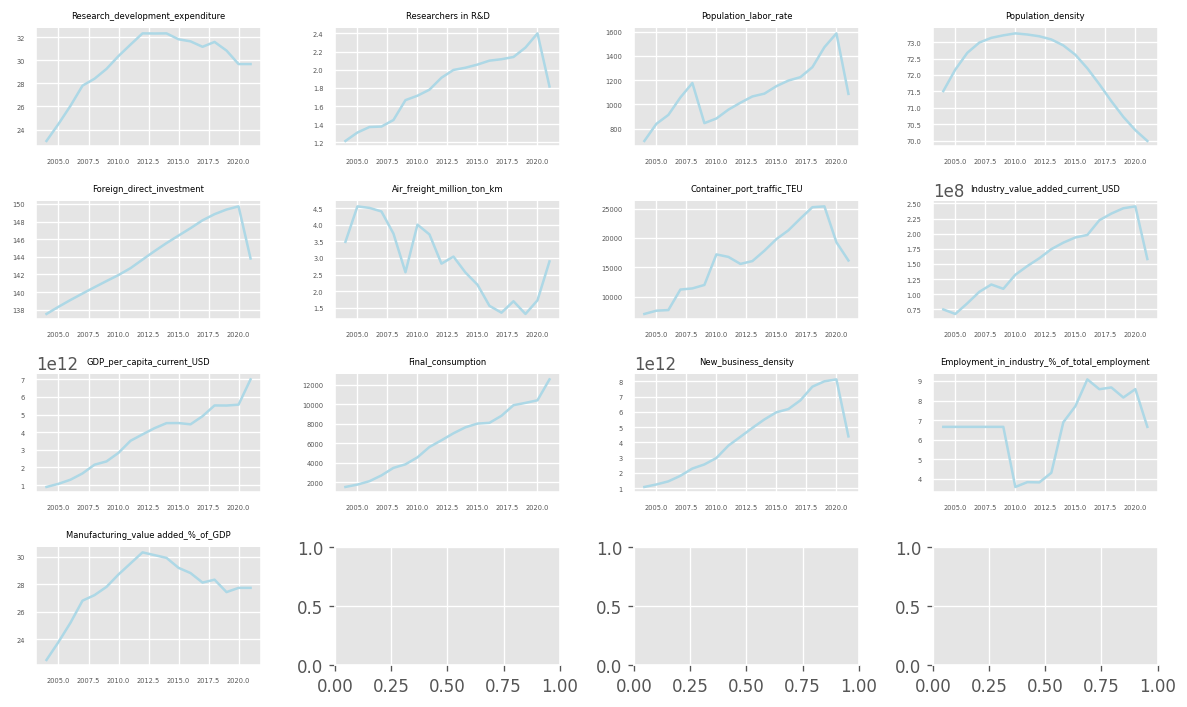

In [10]:
plot_time_series(m_dfs[('CHN','Mean')],len(m_dfs[('CHN','Mean')].columns))

### Correlation checking

In [41]:
from scipy.stats import pearsonr

In [42]:
for con in country:
  for m in method:
    df = m_dfs[(con,m)]
    print(f"=======manufacture {con} {m}=======")
    for col in df:
      corr, _ = pearsonr(df[col], df['Manufacturing_value added_%_of_GDP'])
      print(f'{col} and target: {corr}')
    print("\n")

=======manufacture AUS Mean=======
Employment_in_industry_male and target: 0.39619606758271597
Research_development_expenditure and target: -0.2770374261157327
Researchers in R&D and target: -0.258191583733686
Population_labor_rate and target: 0.48029414231021084
Population_density and target: -0.9526246812791133
Foreign_direct_investment and target: -0.3327961727521197
Air_freight_million_ton_km and target: -0.3966394606266583
Container_port_traffic_TEU and target: -0.5743103256796376
Industry_value_added_current_USD and target: -0.9392903412917006
GDP_per_capita_current_USD and target: -0.9316361369344581
Final_consumption and target: -0.9641847305791243
New_business_density and target: -0.31197319263674056
Employment_in_industry_%_of_total_employment and target: 0.7757451689034309
Manufacturing_value added_%_of_GDP and target: 1.0


=======manufacture AUS Median=======
Employment_in_industry_male and target: 0.3935885390950179
Research_development_expenditure and target: -0.30319938

### Stationarity

In [43]:
def adfuller_simple(series, name,signif=0.05):
  r = adfuller(series, autolag='AIC')
  output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
  p_value = output['pvalue'] 
  if p_value <= signif: 
    print(f"{name}: TRUE")
    return True
  else:
    print(f"{name}: FALSE")
    return False

In [44]:
def adf_testing(df,con,is_manu):
  if is_manu:
    print(f"=======Manufacture {con}=======")
  else:
    print(f"=======Service {con}=======")
  for name, column in df.iteritems():
    adfuller_simple(column, name=column.name)

In [45]:
for m in method:
  print(f"=======Imputation using {m}=======")
  for con in country:
    adf_testing(m_dfs[(con,m)],con,True)
    print("\n")
    adf_testing(s_dfs[(con,m)],con,False)
    print("\n")

=======Imputation using Mean=======
=======Manufacture AUS=======
Employment_in_industry_male: TRUE
Research_development_expenditure: FALSE
Researchers in R&D: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: FALSE
Container_port_traffic_TEU: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
New_business_density: TRUE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service AUS=======
Employment_in_services_male: FALSE
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
Secure_Internet_servers: FALSE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
Unnamed: 9: FALSE
Access_electricity: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Individuals_using_the_Internet_%_of_population: FALSE
Poverty_headcou

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Researchers in R&D: FALSE
Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: FALSE
Container_port_traffic_TEU: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
New_business_density: TRUE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service BRA=======
Employment_in_services_male: FALSE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: FALSE
Secure_Internet_servers: FALSE
School_enrollment_tertiary: FALSE
Population_labor_rate: TRUE
Population_density: FALSE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: FALSE
Poverty_headcount_ratio: FALSE
New_business_density: TRUE
Services_value_added_%_of_GDP: FALS

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Final_consumption: FALSE
New_business_density: FALSE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: FALSE


=======Service CHN=======
Employment_in_services_male: FALSE
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: TRUE
Secure_Internet_servers: FALSE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: FALSE
Poverty_headcount_ratio: FALSE
New_business_density: FALSE
Services_value_added_%_of_GDP: FALSE


=======Manufacture GBR=======
Employment_in_industry_male: FALSE
Research_development_expenditure: FALSE
Researchers in R&D: FALSE
Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Secure_Internet_servers: FALSE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Population_density: TRUE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: FALSE
Poverty_headcount_ratio: TRUE
New_business_density: TRUE
Services_value_added_%_of_GDP: FALSE


=======Manufacture JPN=======
Employment_in_industry_male: FALSE
Research_development_expenditure: TRUE
Researchers in R&D: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
New_business_density: FALSE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service JPN=======
Employment_in_services_male: FAL

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Access_electricity: FALSE
Employment_in_service_%_of_total_employment: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Poverty_headcount_ratio: TRUE
New_business_density: FALSE
Services_value_added_%_of_GDP: FALSE


=======Manufacture SGP=======
Employment_in_industry_male: FALSE
Research_development_expenditure: TRUE
Researchers in R&D: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: FALSE
Container_port_traffic_TEU: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
New_business_density: FALSE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service SGP=======
Employment_in_services_male: FALSE
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
Secure_Inter

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Primary_completion_rate: FALSE
Individuals_using_the_Internet_%_of_population: FALSE
New_business_density: FALSE
Services_value_added_%_of_GDP: FALSE


=======Manufacture USA=======
Employment_in_industry_male: FALSE
Research_development_expenditure: FALSE
Researchers in R&D: FALSE
Population_labor_rate: FALSE
Population_density: TRUE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: FALSE
Container_port_traffic_TEU: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service USA=======
Employment_in_services_male: FALSE
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: TRUE
Secure_Internet_servers: FALSE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Population_density: TRUE
Access_electricity: FALSE


/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Air_freight_million_ton_km: FALSE
Container_port_traffic_TEU: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
New_business_density: TRUE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service BRA=======
Employment_in_services_male: FALSE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: FALSE
Secure_Internet_servers: FALSE
School_enrollment_tertiary: FALSE
Population_labor_rate: TRUE
Population_density: FALSE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: FALSE
Poverty_headcount_ratio: FALSE
New_business_density: TRUE
Services_value_added_%_of_GDP: FALSE


=======Manufacture CAN=======
Employment_in_industry_male: FALSE
Research_development_expenditure: FALSE
Rese

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Employment_in_services_male: FALSE
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: TRUE
Secure_Internet_servers: FALSE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: FALSE
Poverty_headcount_ratio: FALSE
New_business_density: TRUE
Services_value_added_%_of_GDP: FALSE


=======Manufacture GBR=======
Employment_in_industry_male: FALSE
Research_development_expenditure: FALSE
Researchers in R&D: FALSE
Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
New_business_density: FALSE
Employment_in

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Population_density: TRUE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Primary_completion_rate: FALSE
Individuals_using_the_Internet_%_of_population: FALSE
Poverty_headcount_ratio: TRUE
New_business_density: FALSE
Services_value_added_%_of_GDP: FALSE


=======Manufacture JPN=======
Employment_in_industry_male: FALSE
Research_development_expenditure: TRUE
Researchers in R&D: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
New_business_density: FALSE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service JPN=======
Employment_in_services_male: FALSE
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: FALSE
Mobile_cellular_subsc

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Employment_in_service_%_of_total_employment: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Poverty_headcount_ratio: TRUE
New_business_density: FALSE
Services_value_added_%_of_GDP: FALSE


=======Manufacture SGP=======
Employment_in_industry_male: FALSE
Research_development_expenditure: TRUE
Researchers in R&D: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: FALSE
Container_port_traffic_TEU: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
New_business_density: FALSE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service SGP=======
Employment_in_services_male: FALSE
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
Secure_Internet_servers: FALSE
School_

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: FALSE
New_business_density: FALSE
Services_value_added_%_of_GDP: FALSE


=======Manufacture USA=======
Employment_in_industry_male: FALSE
Research_development_expenditure: FALSE
Researchers in R&D: FALSE
Population_labor_rate: FALSE
Population_density: TRUE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: FALSE
Container_port_traffic_TEU: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service USA=======
Employment_in_services_male: FALSE
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: TRUE
Secure_Internet_servers: TRUE
School_enrollment_tertiary: TRUE
Population_labor_rate: FALSE
Population_density: TRUE
Access_electricity: FALSE
Emp

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Final_consumption: FALSE
Services_value_added_%_of_GDP: FALSE


=======Manufacture CAN=======
Employment_in_industry_male: FALSE
Research_development_expenditure: FALSE
Researchers in R&D: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: TRUE


=======Service CAN=======
Employment_in_services_male: FALSE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Individuals_using_the_Internet_%_of_population: FALSE
Poverty_headcount_ratio: TRUE
Services_value_added_%_of_GDP: TRUE


=======Manufa

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Final_consumption: TRUE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: FALSE


=======Service CHN=======
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: FALSE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Services_value_added_%_of_GDP: FALSE


=======Manufacture GBR=======
Population_labor_rate: TRUE
Population_density: TRUE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service GBR=======
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: TRUE
School_enrollment_tertiary: FALSE
Population_labor_rate: TRUE
Population_density: TRUE
Access_electricity: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Indiv

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service IND=======
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: TRUE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Population_density: TRUE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Services_value_added_%_of_GDP: FALSE


=======Manufacture JPN=======
Employment_in_industry_male: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: TRUE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: FALSE


=======Service JPN=======
Employment_in_services_male: TRUE
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: FALSE
School_enrollment_tertiary: TRUE
Population_labor_rate: FALSE
Population_

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Population_density: FALSE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service SGP=======
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Services_value_added_%_of_GDP: FALSE


=======Manufacture USA=======
Employment_in_industry_male: FALSE
Research_development_expenditure: FALSE
Researchers in R&D: FALSE
Population_labor_rate: FALSE
Population_density: TRUE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service USA=======
Employme

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: FALSE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
New_business_density: FALSE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: TRUE


=======Service CAN=======
Employment_in_services_male: FALSE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: FALSE
Secure_Internet_servers: TRUE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Individuals_using_the_Internet_%_of_population: FALSE
New_business_density: FALSE
Services_value_added_%_of_GDP: TRUE


=======Manufacture CHN=======
Population_labor_rate: FALSE
Industry_value_added_curr

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service GBR=======
Net_trade_in_goods_services: FALSE
Population_labor_rate: TRUE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Services_value_added_%_of_GDP: FALSE


=======Manufacture IND=======
Population_labor_rate: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service IND=======
Net_trade_in_goods_services: FALSE
Population_labor_rate: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Services_value_added_%_of_GDP: FALSE


=======Manufacture JPN=======
Research_development_expenditure: FALSE
Researchers in R&D: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: FALSE
Industry_value_added_current_

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Mobile_cellular_subscriptions: TRUE
Secure_Internet_servers: TRUE
Population_labor_rate: FALSE
Population_density: TRUE
Access_electricity: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Individuals_using_the_Internet_%_of_population: FALSE
Services_value_added_%_of_GDP: FALSE


=======Imputation using Rolling statistics=======
=======Manufacture AUS=======
Population_labor_rate: FALSE
Population_density: TRUE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service AUS=======
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: TRUE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Population_density: TRUE
Unnamed: 9: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Individuals_using_the_Internet_%_of_population: FALSE
Services_

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2



GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service BRA=======
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Services_value_added_%_of_GDP: FALSE


=======Manufacture CAN=======
Employment_in_industry_male: FALSE
Research_development_expenditure: FALSE
Researchers in R&D: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: TRUE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: TRUE


=======Service CAN=======
Employment_in_services_male: FALSE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: TRUE
Popu

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Individuals_using_the_Internet_%_of_population: FALSE
Poverty_headcount_ratio: FALSE
Services_value_added_%_of_GDP: TRUE


=======Manufacture CHN=======
Employment_in_industry_male: TRUE
Research_development_expenditure: FALSE
Researchers in R&D: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: FALSE
Container_port_traffic_TEU: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: TRUE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: FALSE


=======Service CHN=======
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: FALSE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: TRUE
Services_value_added_%_of_GDP: FALSE


=======Manufacture GBR=======
Population_labor_rate: FALSE
Population_density: TRUE
Foreign_direct_investment: FALSE

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Employment_in_services_male: TRUE
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: FALSE
School_enrollment_tertiary: TRUE
Population_labor_rate: FALSE
Population_density: TRUE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Primary_completion_rate: FALSE
Individuals_using_the_Internet_%_of_population: TRUE
Services_value_added_%_of_GDP: FALSE


=======Manufacture SGP=======
Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: TRUE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service SGP=======
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: TRUE
Population_labor_rate: TRUE
Population_density: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Services_value

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: TRUE


=======Service USA=======
Employment_in_services_male: FALSE
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Individuals_using_the_Internet_%_of_population: FALSE
Poverty_headcount_ratio: FALSE
Services_value_added_%_of_GDP: FALSE




/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


#### First Order Difference

In [47]:
# perform first order difference
diff_manu = {}
diff_ser = {}
for m in method:
  for con in country:
    diff_manu[(con,m)] = m_dfs[(con,m)].diff().dropna()
    diff_ser[(con,m)] = s_dfs[(con,m)].diff().dropna()

In [48]:
for m in method:
  print(f"=======Imputation using {m}=======")
  for con in country:
    adf_testing(diff_manu[(con,m)],con,True)
    print("\n")
    adf_testing(diff_ser[(con,m)],con,False)
    print("\n")

=======Imputation using Mean=======
=======Manufacture AUS=======
Employment_in_industry_male: TRUE
Research_development_expenditure: FALSE
Researchers in R&D: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
New_business_density: FALSE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service AUS=======
Employment_in_services_male: FALSE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
Secure_Internet_servers: TRUE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
Unnamed: 9: FALSE
Access_electricity: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Individuals_using_the_Internet_%_of_population: FALSE
Poverty_headcount_ratio: TR

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Population_density: FALSE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
New_business_density: FALSE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service BRA=======
Employment_in_services_male: TRUE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: TRUE
Secure_Internet_servers: FALSE
School_enrollment_tertiary: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Poverty_headcount_ratio: TRUE
New_business_density: FALSE
Services_value_added_%_of_GDP: TRUE


=======Manufacture CAN=======
Employment_in_industry_male: TRUE

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Manufacturing_value added_%_of_GDP: TRUE


=======Service CHN=======
Employment_in_services_male: TRUE
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
Secure_Internet_servers: FALSE
School_enrollment_tertiary: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Access_electricity: TRUE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Poverty_headcount_ratio: TRUE
New_business_density: TRUE
Services_value_added_%_of_GDP: TRUE


=======Manufacture GBR=======
Employment_in_industry_male: TRUE
Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_con

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


School_enrollment_tertiary: TRUE
Population_labor_rate: TRUE
Population_density: FALSE
Access_electricity: TRUE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Poverty_headcount_ratio: TRUE
New_business_density: FALSE
Services_value_added_%_of_GDP: TRUE


=======Manufacture JPN=======
Employment_in_industry_male: FALSE
Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
New_business_density: TRUE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: TRUE


=======Service JPN=======
Employment_in_services_male: FALSE
Net_trade_in_goods_services: TRUE
Foreig

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Population_density: FALSE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Poverty_headcount_ratio: TRUE
New_business_density: TRUE
Services_value_added_%_of_GDP: TRUE


=======Manufacture SGP=======
Employment_in_industry_male: TRUE
Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: FALSE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
New_business_density: TRUE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service SGP=======
Employment_in_services_male: TRUE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: TRUE


/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
New_business_density: TRUE
Services_value_added_%_of_GDP: TRUE


=======Manufacture USA=======
Employment_in_industry_male: FALSE
Research_development_expenditure: FALSE
Researchers in R&D: TRUE
Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: TRUE


=======Service USA=======
Employment_in_services_male: FALSE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
Secure_Internet_servers: FALSE
School_enrollment_tertiary: TRUE
Population_labor_rate: TRUE
Population_d

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
New_business_density: FALSE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service BRA=======
Employment_in_services_male: TRUE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: TRUE
Secure_Internet_servers: FALSE
School_enrollment_tertiary: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Access_electricity: TRUE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Poverty_headcount_ratio: TRUE
New_business_density: FALSE
Services_

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
New_business_density: TRUE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: TRUE


=======Service CHN=======
Employment_in_services_male: TRUE
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
Secure_Internet_servers: FALSE
School_enrollment_tertiary: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Access_electricity: TRUE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: FALSE
Poverty_headcount_ratio: TRUE
New_business_density: TRUE
Services_value_added_%_of_GDP: TRUE


=======Manufacture GBR=======
Employment_in_industry_male: TRUE
Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: FALSE
Population_density: FALSE


/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Manufacturing_value added_%_of_GDP: TRUE


=======Service IND=======
Employment_in_services_male: TRUE
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: TRUE
Secure_Internet_servers: FALSE
School_enrollment_tertiary: FALSE
Population_labor_rate: TRUE
Population_density: FALSE
Access_electricity: TRUE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: FALSE
Poverty_headcount_ratio: TRUE
New_business_density: FALSE
Services_value_added_%_of_GDP: TRUE


=======Manufacture JPN=======
Employment_in_industry_male: FALSE
Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_co

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


School_enrollment_tertiary: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
New_business_density: TRUE
Services_value_added_%_of_GDP: TRUE


=======Manufacture USA=======
Employment_in_industry_male: FALSE
Research_development_expenditure: FALSE
Researchers in R&D: TRUE
Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: TRUE


=======Service USA=======
Employment_in_services_male: FALSE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptio

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Poverty_headcount_ratio: TRUE
Services_value_added_%_of_GDP: TRUE


=======Imputation using LOCF=======
=======Manufacture AUS=======
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service AUS=======
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
School_enrollment_tertiary: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Unnamed: 9: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Individuals_using_the_Internet_%_of_population: FALSE
Services_value_added_%_of_GDP: TRUE


=======Manufacture BRA=======
Population_labor_rate: FALSE
Population_density: FAL

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: TRUE


=======Service CHN=======
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: TRUE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Services_value_added_%_of_GDP: TRUE


=======Manufacture GBR=======
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Manufacturing_value added_%_of_GDP: FALSE


=======Service GBR=======
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_sub

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
Manufacturing_value added_%_of_GDP: TRUE


=======Service IND=======
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
School_enrollment_tertiary: FALSE
Population_labor_rate: TRUE
Population_density: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
Services_value_added_%_of_GDP: TRUE


=======Manufacture JPN=======
Employment_in_industry_male: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service JPN=======
Employment_in_services_ma

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Employment_in_service_%_of_total_employment: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Services_value_added_%_of_GDP: TRUE


=======Manufacture SGP=======
Population_labor_rate: FALSE
Population_density: TRUE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: FALSE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Manufacturing_value added_%_of_GDP: TRUE


=======Service SGP=======
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: TRUE
Population_labor_rate: FALSE
Population_density: TRUE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Services_value_added_%_of_GDP: TRUE


=======Manufacture USA=======
Employment_in_industry_male: FALSE
Research_development_expenditure: FALSE
Researchers in R&D: TRUE
Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_in

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Research_development_expenditure: TRUE
Researchers in R&D: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: FALSE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
New_business_density: FALSE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: FALSE


=======Service CAN=======
Employment_in_services_male: TRUE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
Secure_Internet_servers: FALSE
School_enrollment_tertiary: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Individuals_using_the_Internet_%_of_population: FALSE
New_business_density: FALSE
Services_value_added_%_of_GDP: FALSE


=======Manufacture CHN===

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Manufacturing_value added_%_of_GDP: FALSE


=======Service GBR=======
Net_trade_in_goods_services: TRUE
Population_labor_rate: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Services_value_added_%_of_GDP: TRUE


=======Manufacture IND=======
Population_labor_rate: TRUE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
Manufacturing_value added_%_of_GDP: TRUE


=======Service IND=======
Net_trade_in_goods_services: FALSE
Population_labor_rate: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
Services_value_added_%_of_GDP: TRUE


=======Manufacture JPN=======
Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: TRUE
GDP_pe

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Access_electricity: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
Individuals_using_the_Internet_%_of_population: TRUE
Services_value_added_%_of_GDP: TRUE


=======Imputation using Rolling statistics=======
=======Manufacture AUS=======
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Manufacturing_value added_%_of_GDP: TRUE


=======Service AUS=======
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
School_enrollment_tertiary: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Unnamed: 9: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Individuals_using_the_Internet_%_of_population: FALSE
Services_value_added_%_of_GDP: FALSE


=======Manufacture BRA=======
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_d

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Services_value_added_%_of_GDP: FALSE


=======Manufacture CAN=======
Employment_in_industry_male: FALSE
Research_development_expenditure: FALSE
Researchers in R&D: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: TRUE


=======Service CAN=======
Employment_in_services_male: FALSE
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: FALSE
GDP_per_capita_current_USD: FALSE
Fi

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: FALSE


=======Service CHN=======
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: FALSE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Services_value_added_%_of_GDP: TRUE


=======Manufacture GBR=======
Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service GBR=======
Net_trade_in_goods_services: FALSE
Foreign_direct_inve

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Final_consumption: FALSE
Individuals_using_the_Internet_%_of_population: FALSE
Services_value_added_%_of_GDP: FALSE


=======Manufacture IND=======
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service IND=======
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: TRUE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Services_value_added_%_of_GDP: TRUE


=======Manufacture JPN=======
Employment_in_industry_male: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumpti

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


School_enrollment_tertiary: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: FALSE
Services_value_added_%_of_GDP: FALSE


=======Manufacture SGP=======
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service SGP=======
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Services_value_added_%_of_GDP: TRUE


=======Manufacture USA=======
Employment_in_industry_male: FALSE
Research_devel

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


#### Second Order Difference

In [49]:
# perform second order difference
diff2_manu = {}
diff2_ser = {}
for m in method:
  for con in country:
    diff2_manu[(con,m)] = diff_manu[(con,m)].diff().dropna()
    diff2_ser[(con,m)] = diff_ser[(con,m)].diff().dropna()

In [50]:
for m in method:
  print(f"=======Imputation using {m}=======")
  for con in country:
    adf_testing(diff2_manu[(con,m)],con,True)
    print("\n")
    adf_testing(diff2_ser[(con,m)],con,False)
    print("\n")

=======Imputation using Mean=======
=======Manufacture AUS=======
Employment_in_industry_male: TRUE
Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
New_business_density: TRUE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service AUS=======
Employment_in_services_male: TRUE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
Secure_Internet_servers: TRUE
School_enrollment_tertiary: FALSE
Population_labor_rate: TRUE
Population_density: FALSE
Unnamed: 9: FALSE
Access_electricity: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Poverty_headcount_ratio: TRUE
Ne

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Researchers in R&D: TRUE
Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
New_business_density: FALSE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service BRA=======
Employment_in_services_male: TRUE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
Secure_Internet_servers: TRUE
School_enrollment_tertiary: TRUE
Population_labor_rate: TRUE
Population_density: FALSE
Access_electricity: TRUE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Poverty_headcount_ratio: TRUE
New_business_density: FALSE
Services_value_added_%_of_GDP: TRUE


=======Manufac

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service CHN=======
Employment_in_services_male: TRUE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
Secure_Internet_servers: TRUE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
Access_electricity: TRUE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Poverty_headcount_ratio: TRUE
New_business_density: TRUE
Services_value_added_%_of_GDP: TRUE


=======Manufacture GBR=======
Employment_in_industry_male: TRUE
Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_US

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
Secure_Internet_servers: TRUE
School_enrollment_tertiary: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Poverty_headcount_ratio: TRUE
New_business_density: TRUE
Services_value_added_%_of_GDP: FALSE


=======Manufacture JPN=======
Employment_in_industry_male: FALSE
Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: FALSE
Population_density: TRUE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
New_business_density: TRUE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: TRUE




/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Population_labor_rate: FALSE
Population_density: TRUE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: FALSE
Poverty_headcount_ratio: FALSE
New_business_density: TRUE
Services_value_added_%_of_GDP: TRUE


=======Manufacture SGP=======
Employment_in_industry_male: TRUE
Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
New_business_density: TRUE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service SGP=======
Employment_in_services_male: TRUE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_c

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: FALSE
Poverty_headcount_ratio: TRUE
Services_value_added_%_of_GDP: TRUE


=======Imputation using Median=======
=======Manufacture AUS=======
Employment_in_industry_male: TRUE
Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
New_business_density: TRUE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service AUS=======
Employment_in_services_male: TRUE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
Secure_Internet_servers: TRUE
School_enrollment_tertiary: FALSE
Population_labor_rate: TRUE
Population_density: FALSE
Unnamed: 9: FALSE
Access_electri

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
New_business_density: FALSE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service BRA=======
Employment_in_services_male: TRUE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
Secure_Internet_servers: TRUE
School_enrollment_tertiary: TRUE
Population_labor_rate: TRUE
Population_density: FALSE
Access_electricity: TRUE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Poverty_headcount_ratio: TRUE
New_business_density: FALSE
Services_valu

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Final_consumption: FALSE
New_business_density: FALSE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: TRUE


=======Service CHN=======
Employment_in_services_male: TRUE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
Secure_Internet_servers: TRUE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
Access_electricity: TRUE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: FALSE
Poverty_headcount_ratio: TRUE
New_business_density: TRUE
Services_value_added_%_of_GDP: TRUE


=======Manufacture GBR=======
Employment_in_industry_male: TRUE
Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Container

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
Secure_Internet_servers: TRUE
School_enrollment_tertiary: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Primary_completion_rate: FALSE
Individuals_using_the_Internet_%_of_population: TRUE
Poverty_headcount_ratio: TRUE
New_business_density: TRUE
Services_value_added_%_of_GDP: FALSE


=======Manufacture JPN=======
Employment_in_industry_male: FALSE
Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: FALSE
Population_density: TRUE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
New_business_density: TRUE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: TRUE



/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Access_electricity: FALSE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
New_business_density: TRUE
Services_value_added_%_of_GDP: TRUE


=======Manufacture USA=======
Employment_in_industry_male: FALSE
Research_development_expenditure: TRUE
Researchers in R&D: FALSE
Population_labor_rate: FALSE
Population_density: TRUE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: TRUE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service USA=======
Employment_in_services_male: FALSE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: FALSE
Secure_Internet_servers: FALSE
School_enrollment_tertiary: FALSE
Population

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Individuals_using_the_Internet_%_of_population: FALSE
Poverty_headcount_ratio: TRUE
Services_value_added_%_of_GDP: TRUE


=======Imputation using LOCF=======
=======Manufacture AUS=======
Population_labor_rate: TRUE
Population_density: TRUE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service AUS=======
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: TRUE
School_enrollment_tertiary: TRUE
Population_labor_rate: TRUE
Population_density: TRUE
Unnamed: 9: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Services_value_added_%_of_GDP: TRUE


=======Manufacture BRA=======
Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Industry_value_added_curre

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Manufacturing_value added_%_of_GDP: TRUE


=======Service CHN=======
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Population_density: TRUE
GDP_per_capita_current_USD: FALSE
Final_consumption: TRUE
Services_value_added_%_of_GDP: TRUE


=======Manufacture GBR=======
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service GBR=======
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: TRUE
School_enrollment_tertiary: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Access_electricity: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Services_value_added_%_of_GDP: TRUE



/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service IND=======
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Services_value_added_%_of_GDP: FALSE


=======Manufacture JPN=======
Employment_in_industry_male: FALSE
Population_labor_rate: FALSE
Population_density: TRUE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: TRUE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service JPN=======
Employment_in_services_male: TRUE
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: TRUE
School_enrollment_tertiary: TRUE
Population_labor_rate: FALSE
Population_density:

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Final_consumption: TRUE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: FALSE
Services_value_added_%_of_GDP: TRUE


=======Manufacture SGP=======
Population_labor_rate: TRUE
Population_density: TRUE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
Manufacturing_value added_%_of_GDP: TRUE


=======Service SGP=======
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: TRUE
Population_labor_rate: TRUE
Population_density: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
Services_value_added_%_of_GDP: TRUE


=======Manufacture USA=======
Employment_in_industry_male: TRUE
Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: FALSE
Population_density: TRUE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: TRUE
Industry_value_added_current_USD: FALSE
G

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Population_labor_rate: TRUE
Population_density: TRUE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: FALSE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
New_business_density: FALSE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service CAN=======
Employment_in_services_male: TRUE
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: TRUE
Secure_Internet_servers: FALSE
School_enrollment_tertiary: TRUE
Population_labor_rate: TRUE
Population_density: TRUE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Individuals_using_the_Internet_%_of_population: TRUE
New_business_density: FALSE
Services_value_added_%_of_GDP: FALSE


=======Manufacture CHN=======
Population_labor_rate: FALSE
Industry_value_added_current_US

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service GBR=======
Net_trade_in_goods_services: TRUE
Population_labor_rate: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Services_value_added_%_of_GDP: TRUE


=======Manufacture IND=======
Population_labor_rate: FALSE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service IND=======
Net_trade_in_goods_services: TRUE
Population_labor_rate: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Services_value_added_%_of_GDP: FALSE


=======Manufacture JPN=======
Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: FALSE
Population_density: TRUE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: TRUE
Final_consump

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Population_density: TRUE
Access_electricity: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: TRUE
Individuals_using_the_Internet_%_of_population: FALSE
Services_value_added_%_of_GDP: TRUE


=======Imputation using Rolling statistics=======
=======Manufacture AUS=======
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service AUS=======
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
School_enrollment_tertiary: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Unnamed: 9: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Services_value_added_%_of_GDP: TRUE


=======Manufacture BRA=======
Population_labor_rate: FALSE


/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service BRA=======
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Services_value_added_%_of_GDP: TRUE


=======Manufacture CAN=======
Employment_in_industry_male: FALSE
Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: FALSE
Population_density: TRUE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: FALSE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: TRUE


=======Service CAN=======
Employment_in_services_ma

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Poverty_headcount_ratio: TRUE
Services_value_added_%_of_GDP: FALSE


=======Manufacture CHN=======
Employment_in_industry_male: FALSE
Research_development_expenditure: TRUE
Researchers in R&D: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: FALSE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service CHN=======
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
School_enrollment_tertiary: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Services_value_added_%_of_GDP: TRUE


=======Manufacture GBR=======
Population_labor_rate: FALSE
Po

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE


=======Service JPN=======
Employment_in_services_male: FALSE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: TRUE
School_enrollment_tertiary: TRUE
Population_labor_rate: TRUE
Population_density: FALSE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Services_value_added_%_of_GDP: TRUE


=======Manufacture SGP=======
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: FALSE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
Manufacturing_value added_%_of_GDP: TRUE


=======Service SGP=======
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: TRUE
Population_labor_

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: FALSE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: FALSE


=======Service USA=======
Employment_in_services_male: FALSE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: FALSE
Population_labor_rate: TRUE
Population_density: FALSE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Individuals_using_the_Internet_%_of_population: FALSE
Poverty_headcount_ratio: TRUE
Services_value_added_%_of_GDP: TRUE




/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


#### Linear Detrend (TO-DO)

#### Drop Non-stationary variable for model fitting

In [51]:
def drop_non_stat(df):
  adf = df
  for name, column in adf.iteritems():
      if not adfuller_simple(column, name=column.name):
        adf = adf.drop([column.name], axis = 1)
      else:
        continue
  return adf

In [52]:
df_manu = {}
df_ser = {}
for m in method:
  for con in country:
    print(f"==={con} {m} manufacture===")
    df_manu[(con,m)] = drop_non_stat(diff2_manu[(con,m)])
    print(f"==={con} {m} service===")
    df_ser[(con,m)] = drop_non_stat(diff2_ser[(con,m)])

===AUS Mean manufacture===
Employment_in_industry_male: TRUE
Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
New_business_density: TRUE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE
===AUS Mean service===
Employment_in_services_male: TRUE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
Secure_Internet_servers: TRUE
School_enrollment_tertiary: FALSE
Population_labor_rate: TRUE
Population_density: FALSE
Unnamed: 9: FALSE
Access_electricity: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Poverty_headcount_ratio: TRUE
New_business_density: TRUE
Services_value_adde

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
New_business_density: FALSE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE
===BRA Mean service===
Employment_in_services_male: TRUE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
Secure_Internet_servers: TRUE
School_enrollment_tertiary: TRUE
Population_labor_rate: TRUE
Population_density: FALSE
Access_electricity: TRUE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Poverty_headcount_ratio: TRUE
New_business_density: FALSE
Services_value_added_%_of_GDP: TRUE
===CAN Mean manufacture===
Employment_in_indus

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
Secure_Internet_servers: TRUE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
Access_electricity: TRUE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Poverty_headcount_ratio: TRUE
New_business_density: TRUE
Services_value_added_%_of_GDP: TRUE
===GBR Mean manufacture===
Employment_in_industry_male: TRUE
Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
New_business_density: TRUE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_va

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


School_enrollment_tertiary: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Poverty_headcount_ratio: TRUE
New_business_density: TRUE
Services_value_added_%_of_GDP: FALSE
===JPN Mean manufacture===
Employment_in_industry_male: FALSE
Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: FALSE
Population_density: TRUE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
New_business_density: TRUE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: TRUE
===JPN Mean service===
Employment_in_services_male: FALSE
Net_trade_in_goods_services: TRUE
Foreign_direct

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Population_labor_rate: FALSE
Population_density: TRUE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: FALSE
Poverty_headcount_ratio: FALSE
New_business_density: TRUE
Services_value_added_%_of_GDP: TRUE
===SGP Mean manufacture===
Employment_in_industry_male: TRUE
Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
New_business_density: TRUE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE
===SGP Mean service===
Employment_in_services_male: TRUE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_su

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Access_electricity: FALSE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
New_business_density: TRUE
Services_value_added_%_of_GDP: TRUE
===USA Mean manufacture===
Employment_in_industry_male: FALSE
Research_development_expenditure: TRUE
Researchers in R&D: FALSE
Population_labor_rate: FALSE
Population_density: TRUE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: TRUE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: FALSE
===USA Mean service===
Employment_in_services_male: FALSE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: FALSE
Secure_Internet_servers: FALSE
School_enrollment_tertiary: FALSE
Population_labor_rat

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
New_business_density: FALSE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE
===BRA Median service===
Employment_in_services_male: TRUE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
Secure_Internet_servers: TRUE
School_enrollment_tertiary: TRUE
Population_labor_rate: TRUE
Population_density: FALSE
Access_electricity: TRUE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Poverty_headcount_ratio: TRUE
New_business_density: FALSE
Services_value_added_%_of_GDP: TRUE
===CAN Median manufacture===
Employment_in_industry_male: TRUE
Research_

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Employment_in_services_male: TRUE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
Secure_Internet_servers: TRUE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
Access_electricity: TRUE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: FALSE
Poverty_headcount_ratio: TRUE
New_business_density: TRUE
Services_value_added_%_of_GDP: TRUE
===GBR Median manufacture===
Employment_in_industry_male: TRUE
Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
New_business_density: TRUE
Employment_in_industry_%_of_to

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Population_labor_rate: FALSE
Population_density: FALSE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Primary_completion_rate: FALSE
Individuals_using_the_Internet_%_of_population: TRUE
Poverty_headcount_ratio: TRUE
New_business_density: TRUE
Services_value_added_%_of_GDP: FALSE
===JPN Median manufacture===
Employment_in_industry_male: FALSE
Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: FALSE
Population_density: TRUE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
New_business_density: TRUE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: TRUE
===JPN Median service===
Employment_in_services_male: FALSE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: FALSE
Mobile_ce

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Access_electricity: FALSE
Employment_in_service_%_of_total_employment: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: FALSE
Poverty_headcount_ratio: FALSE
New_business_density: TRUE
Services_value_added_%_of_GDP: TRUE
===SGP Median manufacture===
Employment_in_industry_male: TRUE
Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
New_business_density: TRUE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE
===SGP Median service===
Employment_in_services_male: TRUE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: TRUE
Secure_Internet_servers: TRUE
Sc

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Final_consumption: FALSE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
New_business_density: TRUE
Services_value_added_%_of_GDP: TRUE
===USA Median manufacture===
Employment_in_industry_male: FALSE
Research_development_expenditure: TRUE
Researchers in R&D: FALSE
Population_labor_rate: FALSE
Population_density: TRUE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: TRUE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: FALSE
===USA Median service===
Employment_in_services_male: FALSE
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: FALSE
Secure_Internet_servers: FALSE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Population_density: TRUE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: 

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Research_development_expenditure: FALSE
Researchers in R&D: TRUE
Population_labor_rate: TRUE
Population_density: TRUE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: FALSE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE
===CAN LOCF service===
Employment_in_services_male: TRUE
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: TRUE
Population_labor_rate: TRUE
Population_density: TRUE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Individuals_using_the_Internet_%_of_population: TRUE
Poverty_headcount_ratio: FALSE
Services_value_added_%_of_GDP: FALSE
===CHN LOCF manufacture===
Employment_in_industry_male: TRUE
Research_development_expenditure: FALSE
Researchers in R&D: FALSE
Population_labor_rate: FALS

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Population_density: TRUE
GDP_per_capita_current_USD: FALSE
Final_consumption: TRUE
Services_value_added_%_of_GDP: TRUE
===GBR LOCF manufacture===
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Manufacturing_value added_%_of_GDP: TRUE
===GBR LOCF service===
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: TRUE
School_enrollment_tertiary: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Access_electricity: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Services_value_added_%_of_GDP: TRUE
===IND LOCF manufacture===
Population_labor_rate: FALSE
Population_density: FALS

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Manufacturing_value added_%_of_GDP: TRUE
===IND LOCF service===
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
School_enrollment_tertiary: FALSE
Population_labor_rate: FALSE
Population_density: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Services_value_added_%_of_GDP: FALSE
===JPN LOCF manufacture===
Employment_in_industry_male: FALSE
Population_labor_rate: FALSE
Population_density: TRUE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: TRUE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE
===JPN LOCF service===
Employment_in_services_male: TRUE
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: TRUE
School_enrollment_tertiary: TRUE
Population_labor_rate: FALSE
Population_density: TRUE
Access_el

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: FALSE
Services_value_added_%_of_GDP: TRUE
===SGP LOCF manufacture===
Population_labor_rate: TRUE
Population_density: TRUE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
Manufacturing_value added_%_of_GDP: TRUE
===SGP LOCF service===
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: TRUE
Population_labor_rate: TRUE
Population_density: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
Services_value_added_%_of_GDP: TRUE
===USA LOCF manufacture===
Employment_in_industry_male: TRUE
Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: FALSE
Population_density: TRUE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: TRUE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
New_business_density: FALSE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE
===CAN NOCB service===
Employment_in_services_male: TRUE
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: FALSE
Mobile_cellular_subscriptions: TRUE
Secure_Internet_servers: FALSE
School_enrollment_tertiary: TRUE
Population_labor_rate: TRUE
Population_density: TRUE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Individuals_using_the_Internet_%_of_population: TRUE
New_business_density: FALSE
Services_value_added_%_of_GDP: FALSE
===CHN NOCB manufacture===
Population_labor_rate: FALSE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Manufacturing_value added_%_of_GDP: TRUE
===CHN NOCB service===
Net_trade_in_goods_servic

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Net_trade_in_goods_services: TRUE
Population_labor_rate: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Services_value_added_%_of_GDP: TRUE
===IND NOCB manufacture===
Population_labor_rate: FALSE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Manufacturing_value added_%_of_GDP: TRUE
===IND NOCB service===
Net_trade_in_goods_services: TRUE
Population_labor_rate: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Services_value_added_%_of_GDP: FALSE
===JPN NOCB manufacture===
Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: FALSE
Population_density: TRUE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
New_business_density: FALSE
Manufacturing_value added_%_of_GDP: TRUE
===JPN NOCB service===
Net_trade_in_goods_services: TRUE
Fore

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Final_consumption: TRUE
Individuals_using_the_Internet_%_of_population: FALSE
Services_value_added_%_of_GDP: TRUE
===AUS Rolling statistics manufacture===
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Manufacturing_value added_%_of_GDP: TRUE
===AUS Rolling statistics service===
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
School_enrollment_tertiary: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Unnamed: 9: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Services_value_added_%_of_GDP: TRUE
===BRA Rolling statistics manufacture===
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Industry_value_added_current_USD: T

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Population_density: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Services_value_added_%_of_GDP: TRUE
===CAN Rolling statistics manufacture===
Employment_in_industry_male: FALSE
Research_development_expenditure: TRUE
Researchers in R&D: TRUE
Population_labor_rate: FALSE
Population_density: TRUE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: FALSE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: TRUE
===CAN Rolling statistics service===
Employment_in_services_male: TRUE
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
Population_labor_rate: FALSE
Population_density: TRUE
Access_electricity: FALSE
Employment_in_service_%_of_total_employment: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Poverty_headcoun

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: FALSE
===CHN Rolling statistics service===
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
School_enrollment_tertiary: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
GDP_per_capita_current_USD: FALSE
Final_consumption: FALSE
Services_value_added_%_of_GDP: TRUE
===GBR Rolling statistics manufacture===
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Manufacturing_value added_%_of_GDP: TRUE
===GBR Rolling statistics service===
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: FALSE
School_enrollment_tertiary: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
Access_electricity: FALSE
GDP_pe

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Manufacturing_value added_%_of_GDP: TRUE
===IND Rolling statistics service===
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: TRUE
School_enrollment_tertiary: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Services_value_added_%_of_GDP: TRUE
===JPN Rolling statistics manufacture===
Employment_in_industry_male: FALSE
Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: TRUE
Employment_in_industry_%_of_total_employment: TRUE
Manufacturing_value added_%_of_GDP: TRUE
===JPN Rolling statistics service===
Employment_in_services_male: FALSE
Foreign_direct_investme

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Individuals_using_the_Internet_%_of_population: TRUE
Services_value_added_%_of_GDP: TRUE
===SGP Rolling statistics manufacture===
Population_labor_rate: FALSE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: FALSE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
Manufacturing_value added_%_of_GDP: TRUE
===SGP Rolling statistics service===
Net_trade_in_goods_services: TRUE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: TRUE
Population_labor_rate: FALSE
Population_density: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
Services_value_added_%_of_GDP: TRUE
===USA Rolling statistics manufacture===
Employment_in_industry_male: FALSE
Research_development_expenditure: TRUE
Researchers in R&D: FALSE
Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: FALSE
Air_freight_million_ton_km: FALSE
Industry_value_added_current_USD: TRUE
GDP_per_capita_current

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


### Model Fitting

#### Train-test split

In [53]:
def split_train_test(df, valid_num = 5):
    train = df[:-valid_num]
    valid = df[-valid_num:]
    return train, valid

train_manu = {}
valid_manu = {}
train_ser = {}
valid_ser = {}
for m in method:
  for con in country:
    train_manu[(con,m)], valid_manu[(con,m)]= split_train_test(df_manu[(con,m)])
    train_ser[(con,m)], valid_ser[(con,m)]= split_train_test(df_ser[(con,m)])

#### VAR Model Fitting

In [54]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [55]:
# select the order of model
model_manu = {}
model_ser = {}
for m in method:
  for con in country:
    model = VAR(endog=train_manu[(con,m)])
    res = model.fit()
    model_manu[(con,m)] = res
    model = VAR(endog=train_ser[(con,m)])
    res = model.fit()
    model_ser[(con,m)] = res

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was pro

#### Diagnostic Check

Using Ljung-Box test to perform diagnostic check

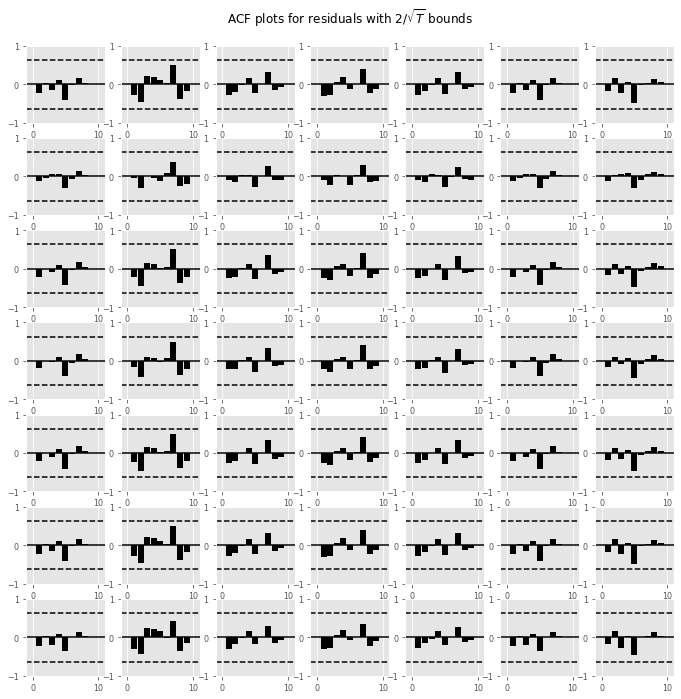

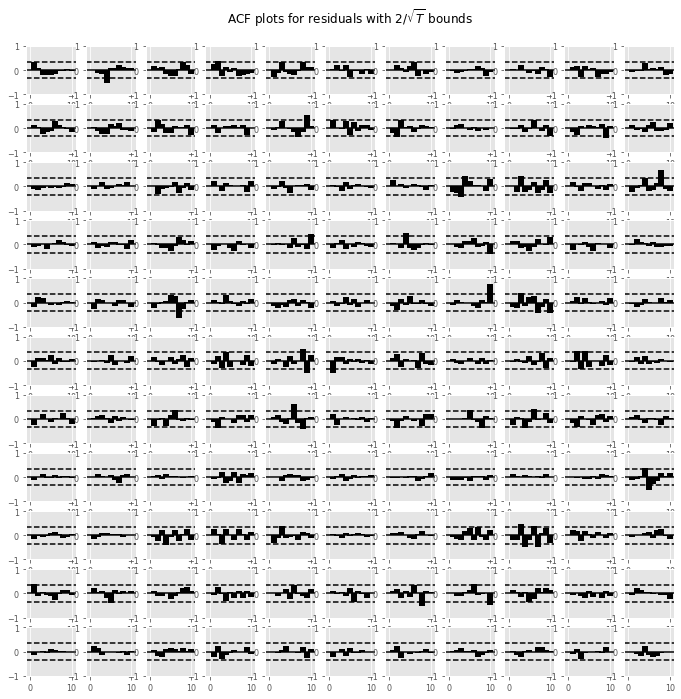

In [56]:
# for m in method:
#   for con in country:
#     model_manu[(con,m)].plot_acorr(nlags=10, resid=True, linewidth=6)
#     model_ser[(con,m)].plot_acorr(nlags=10, resid=True, linewidth=6)
#     plt.show()
# can be used as reference for all residual checking
model_manu[('CHN','Mean')].plot_acorr(nlags=10, resid=True, linewidth=6)
model_ser[('CHN','Mean')].plot_acorr(nlags=10, resid=True, linewidth=6)
plt.show()

#### Forecasting

In [57]:
forecast_manu = {}
forecast_ser = {}
def forecast_var(model, train,valid,con, manu):
  forecast = model.forecast(train.values, steps = len(valid))
  df_forecast = pd.DataFrame(data = forecast,columns = train.columns,index = valid.index)
  manu[(con,m)] = df_forecast
for m in method:
  for con in country:
    forecast_var(model_manu[(con,m)],train_manu[(con,m)], valid_manu[(con,m)],con, forecast_manu)
    forecast_var(model_ser[(con,m)],train_ser[(con,m)], valid_ser[(con,m)],con, forecast_ser)

In [58]:
def invert_second_diff(df,test_obs = 5):
  df_ori = df
  for col_name in df_ori:
    df_ori[col_name+"_1d"] = df[col_name].iloc[-test_obs-1] - df[col_name].iloc[-test_obs-2] +df[col_name].cumsum()
    df_ori[col_name+"_forecasted"] = df[col_name].iloc[-test_obs-1] + df[col_name+"_1d"].cumsum()
    df[col_name] = df_ori[[col_name+"_forecasted"]]
  return df

### Evaluation

In [59]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error

In [60]:
m_metrics = {}
s_metrics = {}
for m in method:
  for con in country:
    if 'Manufacturing_value added_%_of_GDP' in valid_manu[(con,m)].columns:
      y = valid_manu[(con,m)]['Manufacturing_value added_%_of_GDP']
      yhat = forecast_manu[(con,m)]['Manufacturing_value added_%_of_GDP']
      mae = mean_absolute_error(y, yhat)
      mape = mean_absolute_percentage_error(y, yhat)
      rmse = sqrt(mean_squared_error(y, yhat))
      eval =  [mae,rmse,mape]
    #print(mae, mse, rmse, con)
      m_metrics[(con,m)] = eval
    else:
      print(f'Target variable for manufaturce {con} {m} is non-stationary.')
      m_metrics[(con,m)] = [np.nan,np.nan,np.nan]

    if 'Services_value_added_%_of_GDP' in valid_ser[(con,m)].columns:
      y = valid_ser[(con,m)]['Services_value_added_%_of_GDP']
      yhat = forecast_ser[(con,m)]['Services_value_added_%_of_GDP']
      mae = mean_absolute_error(y, yhat)
      mape = mean_absolute_percentage_error(y, yhat)
      rmse = sqrt(mean_squared_error(y, yhat))
      eval = [mae,rmse,mape]
      #print(mae, mse, rmse, con)
      s_metrics[(con,m)] = eval
    else:
      print(f'Target variable for service {con} {m} is non-stationary.')
      s_metrics[(con,m)] = [np.nan,np.nan,np.nan]

Target variable for service CAN Mean is non-stationary.
Target variable for service IND Mean is non-stationary.
Target variable for manufaturce USA Mean is non-stationary.
Target variable for service CAN Median is non-stationary.
Target variable for service IND Median is non-stationary.
Target variable for manufaturce USA Median is non-stationary.
Target variable for service CAN LOCF is non-stationary.
Target variable for service IND LOCF is non-stationary.
Target variable for manufaturce USA LOCF is non-stationary.
Target variable for service CAN NOCB is non-stationary.
Target variable for service IND NOCB is non-stationary.
Target variable for manufaturce USA NOCB is non-stationary.
Target variable for service CAN Rolling statistics is non-stationary.
Target variable for manufaturce CHN Rolling statistics is non-stationary.
Target variable for manufaturce USA Rolling statistics is non-stationary.


In [61]:
m_eval = pd.DataFrame(m_metrics).transpose()
m_eval.columns = ['MAE', 'RMSE','MAPE']

m_eval

,,MAE,RMSE,MAPE
AUS,Mean,0.165288,0.235609,1.358758
BRA,Mean,2.064087,2.562537,76.225917
CAN,Mean,0.469060,0.583807,0.919030
CHN,Mean,4.257761,5.409354,4.998291
GBR,Mean,0.337290,0.411066,3.656736
IND,Mean,0.566133,0.625066,23.916520
JPN,Mean,0.567911,0.663020,4.552637
SGP,Mean,2.255424,2.546798,1.335980
USA,Mean,NaN,NaN,NaN
AUS,Median,0.197343,0.232255,1.554515


In [31]:
s_eval = pd.DataFrame(s_metrics).transpose()
s_eval.columns = ['MAE','RMSE','MAPE']
s_eval

,,MAE,RMSE,MAPE
AUS,Mean,0.977937,1.117162,1.712667
BRA,Mean,3.631710,4.490391,3.056254
CAN,Mean,NaN,NaN,NaN
CHN,Mean,0.779975,0.867505,1.075446
GBR,Mean,0.856581,1.055574,115.549219
IND,Mean,NaN,NaN,NaN
JPN,Mean,0.993733,1.312666,2.320864
SGP,Mean,1.718686,2.024588,1.324278
USA,Mean,0.873536,1.164922,1.294243
AUS,Median,1.771021,1.912138,3.468688


### Special case for manufacture USA and Service IND

By difference result, we can see that manufacture USA and Service IND can be stationary with first order difference.

In [62]:
# drop non-stationary
usa_manu={}
can_ser= {}
for m in method:
  usa_manu[m] = drop_non_stat(diff_manu[('USA',m)])
  can_ser[m] = drop_non_stat(diff_ser[('IND',m)])

Employment_in_industry_male: FALSE
Research_development_expenditure: FALSE
Researchers in R&D: TRUE
Population_labor_rate: TRUE
Population_density: FALSE
Foreign_direct_investment: TRUE
Air_freight_million_ton_km: TRUE
Container_port_traffic_TEU: TRUE
Industry_value_added_current_USD: FALSE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
Employment_in_industry_%_of_total_employment: FALSE
Manufacturing_value added_%_of_GDP: TRUE
Employment_in_services_male: TRUE
Net_trade_in_goods_services: FALSE
Foreign_direct_investment: TRUE
Mobile_cellular_subscriptions: TRUE
Secure_Internet_servers: FALSE
School_enrollment_tertiary: TRUE
Population_labor_rate: TRUE
Population_density: FALSE
Access_electricity: TRUE
Employment_in_service_%_of_total_employment: TRUE
GDP_per_capita_current_USD: TRUE
Final_consumption: FALSE
Primary_completion_rate: TRUE
Individuals_using_the_Internet_%_of_population: TRUE
Poverty_headcount_ratio: TRUE
New_business_density: FALSE
Services_value_added_%_of_GD

In [63]:
train_usa = {}
valid_usa = {}
train_can = {}
valid_can = {}
for m in method:
  train_usa[m], valid_usa[m]= split_train_test(usa_manu[m])
  train_can[m], valid_can[m]= split_train_test(can_ser[m])

In [64]:
# select the order of model
model_usa = {}
model_can = {}
for m in method:
  model = VAR(endog=train_usa[m])
  res = model.fit()
  model_usa[m] = res
  model = VAR(endog=train_can[m])
  res = model.fit()
  model_can[m] = res

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was pro

In [65]:
forecast_usa = {}
forecast_can = {}
for m in method:
  forecast_var(model_usa[m],train_usa[m], valid_usa[m],'USA', forecast_usa)
  forecast_var(model_can[m],train_can[m], valid_can[m],'IND', forecast_can)

In [66]:
valid_can['Mean']

,Employment_in_services_male,Foreign_direct_investment,Mobile_cellular_subscriptions,School_enrollment_tertiary,Population_labor_rate,Access_electricity,Employment_in_service_%_of_total_employment,GDP_per_capita_current_USD,Primary_completion_rate,Individuals_using_the_Internet_%_of_population,Poverty_headcount_ratio,Services_value_added_%_of_GDP
Year,,,,,,,,,,,,
2017,0.360001,-0.430047,4.109328e+07,0.612909,0.263925,2.907150,0.450000,248.112778,-1.856949,1.700000,-4.700000,-0.078511
2018,0.369999,0.050898,7.119592e+06,0.618422,0.228555,3.575050,0.440000,17.592056,-10.021133,1.881300,-2.300000,0.760676
2019,0.500000,0.229167,-2.454151e+07,0.512350,0.237069,1.608269,0.460000,73.985821,7.308876,9.318700,-1.100000,1.676103
2020,-4.644482,0.625283,2.229471e+06,0.868429,0.261689,1.691734,-9.355517,-139.143828,2.897636,13.600000,19.190909,-1.670812
2021,0.000000,-1.453936,-8.465133e+08,-15.973575,0.179688,-28.043162,0.000000,344.333278,-10.206512,-35.834192,0.000000,-0.746430


In [67]:
m_metrics = {}
s_metrics = {}
for m in method:
  if 'Manufacturing_value added_%_of_GDP' in valid_usa[m].columns:
    y = valid_usa[m]['Manufacturing_value added_%_of_GDP']
    yhat = forecast_usa[('USA',m)]['Manufacturing_value added_%_of_GDP']
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = sqrt(mean_squared_error(y, yhat))
    eval = [mae,rmse,mape]
      #print(mae, mse, rmse, con)
    m_metrics[('USA',m)] = eval
  else:
    print(f'Target variable for manufaturce USA {m} is non-stationary.')
    m_metrics[('USA',m)] = [np.nan,np.nan,np.nan]

  if 'Services_value_added_%_of_GDP' in valid_can[m]:
    y = valid_can[m]['Services_value_added_%_of_GDP']
    yhat = forecast_can[('IND',m)]['Services_value_added_%_of_GDP']
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = sqrt(mean_squared_error(y, yhat))
    eval =  [mae,rmse,mape]
        #print(mae, mse, rmse, con)
    s_metrics[('IND',m)] = eval
  else:
    print(f'Target variable for service IND {m} is non-stationary.')
    s_metrics[('IND',m)] = [np.nan,np.nan,np.nan]

In [68]:
m_eval = pd.DataFrame(m_metrics).transpose()
m_eval.columns = ['MAE', 'RMSE','MAPE']
m_eval

MAE      RMSE      MAPE
USA Mean                0.219496  0.231899  2.966992
    Median              0.219514  0.232040  2.973799
    LOCF                0.158571  0.167074  1.655811
    NOCB                0.175879  0.184274  1.656395
    Rolling statistics  0.103883  0.115779  1.059081

In [69]:
s_eval = pd.DataFrame(s_metrics).transpose()
s_eval.columns = ['MAE','RMSE','MAPE']
s_eval

MAE      RMSE      MAPE
IND Mean                1.001480  1.195332  1.209182
    Median              1.064655  1.223096  1.779342
    LOCF                1.066787  1.236657  2.087945
    NOCB                1.070749  1.237248  2.098501
    Rolling statistics  0.143334  0.174563  1.484907